# Ensemble - Adaptive Boosting

## References

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

## Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [2]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [3]:

# Source: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Date: The date of observation
# X02: Location: The common name of the location of the weather station
# X03: MinTemp: The minimum temperature in degrees celsius
# X04: MaxTemp: The maximum temperature in degrees celsius
# X05: Rainfall: The amount of rainfall recorded for the day in mm
# X06: Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
# X07: Sunshine: The number of hours of bright sunshine in the day.
# X08: WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
# X09: WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
# X10: WindDir9am: Direction of the wind at 9am
# X11: WindDir3pm: Direction of the wind at 3pm
# X12: WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
# X13: WindSpeed3pm: Wind speed (km/hr) averaged over 10 minutes prior to 3pm
# X14: Humidity9am: Humidity (percent) at 9am
# X15: Humidity3pm: Humidity (percent) at 3pm
# X16: Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
# X17: Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
# X18: Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
# X19: Cloud3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
# X20: Temp9am: Temperature (degrees C) at 9am
# X21: Temp3pm: Temperature (degrees C) at 3pm
# X22: RainToday: Boolean: 1  if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
#   y: RainTomorrow: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

In [4]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/weather_aus.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'RainTomorrow'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [6]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,y
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X01     145460 non-null  object 
 1   X02     145460 non-null  object 
 2   X03     143975 non-null  float64
 3   X04     144199 non-null  float64
 4   X05     142199 non-null  float64
 5   X06     82670 non-null   float64
 6   X07     75625 non-null   float64
 7   X08     135134 non-null  object 
 8   X09     135197 non-null  float64
 9   X10     134894 non-null  object 
 10  X11     141232 non-null  object 
 11  X12     143693 non-null  float64
 12  X13     142398 non-null  float64
 13  X14     142806 non-null  float64
 14  X15     140953 non-null  float64
 15  X16     130395 non-null  float64
 16  X17     130432 non-null  float64
 17  X18     89572 non-null   float64
 18  X19     86102 non-null   float64
 19  X20     143693 non-null  float64
 20  X21     141851 non-null  float64
 21  X22     14

In [8]:
# describe data
df1.describe()

,X03,X04,X05,X06,X07,X09,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [9]:
# check missing values
df1.isna().sum()

X01        0
X02        0
X03     1485
X04     1261
X05     3261
X06    62790
X07    69835
X08    10326
X09    10263
X10    10566
X11     4228
X12     1767
X13     3062
X14     2654
X15     4507
X16    15065
X17    15028
X18    55888
X19    59358
X20     1767
X21     3609
X22     3261
y       3267
dtype: int64

## Data Cleaning and Transformation

In [10]:
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,y
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [11]:
# convert to datetime format
df1['X01'] = pd.to_datetime(df1['X01'], format = '%Y-%m-%d')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   X01     145460 non-null  datetime64[ns]
 1   X02     145460 non-null  object        
 2   X03     143975 non-null  float64       
 3   X04     144199 non-null  float64       
 4   X05     142199 non-null  float64       
 5   X06     82670 non-null   float64       
 6   X07     75625 non-null   float64       
 7   X08     135134 non-null  object        
 8   X09     135197 non-null  float64       
 9   X10     134894 non-null  object        
 10  X11     141232 non-null  object        
 11  X12     143693 non-null  float64       
 12  X13     142398 non-null  float64       
 13  X14     142806 non-null  float64       
 14  X15     140953 non-null  float64       
 15  X16     130395 non-null  float64       
 16  X17     130432 non-null  float64       
 17  X18     89572 non-null   floa

In [12]:
# add year column
df1['X23'] = df1.X01.dt.year
# add month column
df1['X24'] = df1.X01.dt.month
# add day column
df1['X25'] = df1.X01.dt.day
# add weekday column
df1['X26'] = df1.X01.dt.weekday
# add quarter column
df1['X27'] = df1.X01.dt.quarter
# add is day of year
df1['X28'] = df1.X01.dt.day_of_year
# add is leap year
df1['X29'] = df1.X01.dt.is_leap_year

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X21,X22,y,X23,X24,X25,X26,X27,X28,X29
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,1,0,4,336,True
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,2,1,4,337,True
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,3,2,4,338,True
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,4,3,4,339,True
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,5,4,4,340,True


In [13]:
# remove usless columns
X_exclude = ['X01']
df1 = df1.drop(columns = X_exclude, errors = 'ignore')
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,...,X21,X22,y,X23,X24,X25,X26,X27,X28,X29
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,21.8,No,No,2008,12,1,0,4,336,True
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,24.3,No,No,2008,12,2,1,4,337,True
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,23.2,No,No,2008,12,3,2,4,338,True
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,26.5,No,No,2008,12,4,3,4,339,True
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,29.7,No,No,2008,12,5,4,4,340,True


In [14]:
# response column
y_col = new_y_col
y_col

'y'

In [15]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29'],
      dtype='object')

In [16]:
# get unique y_labels
y_labels = ['No', 'Yes']
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'No': 0, 'Yes': 1}

In [17]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,...,X21,X22,y,X23,X24,X25,X26,X27,X28,X29
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,21.8,No,0.0,2008,12,1,0,4,336,True
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,24.3,No,0.0,2008,12,2,1,4,337,True
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,23.2,No,0.0,2008,12,3,2,4,338,True
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,26.5,No,0.0,2008,12,4,3,4,339,True
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,29.7,No,0.0,2008,12,5,4,4,340,True


In [18]:
# # remove rows with missing valus
# for X in df1.columns:
#   cond1 = ~((df1[X].isna()))
#   df1 = df1.loc[cond1,:]
  
# df1.isna().sum()

In [19]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,...,X21,X22,y,X23,X24,X25,X26,X27,X28,X29
0,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,...,21.8,0,0.0,2008,12,1,0,4,336,True
1,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,...,24.3,0,0.0,2008,12,2,1,4,337,True
2,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,...,23.2,0,0.0,2008,12,3,2,4,338,True
3,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,...,26.5,0,0.0,2008,12,4,3,4,339,True
4,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,...,29.7,0,0.0,2008,12,5,4,4,340,True


In [20]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # upsample minority label
# df_temp = df1.loc[cond2,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = True,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # update df1
# df1 = pd.concat([df1, df_upsample], ignore_index = True)
# df1.info()

In [21]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [22]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,...,X21,X22,y,X23,X24,X25,X26,X27,X28,X29
0,-1.531666,0.188477,-0.045139,-0.207704,NaN,NaN,0.944029,0.291377,1.027318,1.265374,...,0.016811,-0.53986,0.0,-1.879575,1.634076,-1.672844,-1.500378,1.376227,1.495149,1.756264
1,-1.531666,-0.749247,0.263892,-0.278475,NaN,NaN,1.145167,0.291377,-0.394948,1.476352,...,0.377216,-0.53986,0.0,-1.879575,1.634076,-1.559140,-1.000200,1.376227,1.504693,1.756264
2,-1.531666,0.110333,0.348173,-0.278475,NaN,NaN,1.346306,0.438360,1.027318,1.476352,...,0.218638,-0.53986,0.0,-1.879575,1.634076,-1.445436,-0.500021,1.376227,1.514237,1.756264
3,-1.531666,-0.467930,0.671251,-0.278475,NaN,NaN,-0.866215,-1.178453,0.214594,-1.688306,...,0.694374,-0.53986,0.0,-1.879575,1.634076,-1.331732,0.000158,1.376227,1.523781,1.756264
4,-1.531666,0.829255,1.275266,-0.160523,NaN,NaN,0.944029,0.070902,-1.410853,-0.211466,...,1.155693,-0.53986,0.0,-1.879575,1.634076,-1.218028,0.500337,1.376227,1.533324,1.756264


In [23]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [24]:
# # melt df2 into a dataframe where cols become stacked as rows
# df3 = df2.melt(
#   id_vars = y_col,
#   value_vars = X_cols,
#   var_name = 'X',
#   value_name = "X_value"
# )
# df3.head()

## Visualize Dataset

In [25]:
df2.y.unique().size

3

In [27]:
# figure setup
fig_cols = 4
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 50)

In [28]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  # p2 = sns.boxenplot(ax = axes[row, col], data = df2, y = y_col, x = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, y = y_col, x = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, y = y_col, x = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [305]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [306]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [307]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(6665, 9)

In [308]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

In [309]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

### Select Features Using Model Selection Methods

In [310]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [311]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 10,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [312]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [313]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.03615925, 0.02514255, 0.37408314, 0.03646194, 0.1312128 ,
       0.15306207, 0.05979777, 0.10382674, 0.08025372])

In [314]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.0802537182994143

In [315]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [316]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [317]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X04', 'X06', 'X07', 'X09', 'X10'], dtype=object)

## Train and Test ML Model

In [318]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
# X_include = ['X03', 'X05', 'X10']
print(len(X_include))
print(X_include)

5
['X04' 'X06' 'X07' 'X09' 'X10']


In [327]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  # stratify = y, shuffle = True, 
  train_size = 0.9, random_state = random_state
)

In [335]:
# initialize estimtor model 
estimator_model = DecisionTreeClassifier(
  random_state = random_state
)

In [336]:
# initialize Bagging Model
myfit = AdaBoostClassifier(
  estimator = estimator_model, 
  n_estimators = 100,
  random_state = random_state
)

In [337]:
# fit model
temp = myfit.fit(X_train, y_train)

In [338]:
# get predictions on test data
y_hat = myfit.predict(X_test)

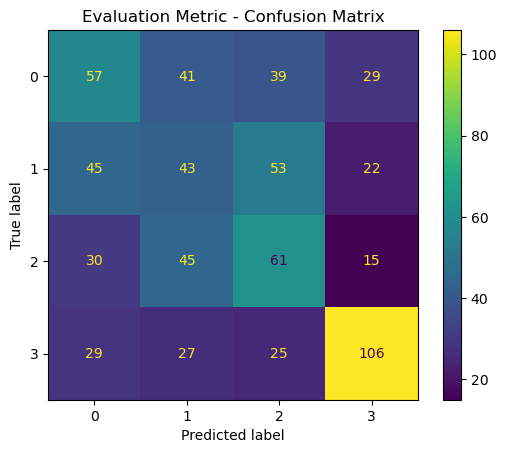

In [339]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [340]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.35      0.34      0.35       166
           1       0.28      0.26      0.27       163
           2       0.34      0.40      0.37       151
           3       0.62      0.57      0.59       187

    accuracy                           0.40       667
   macro avg       0.40      0.39      0.39       667
weighted avg       0.41      0.40      0.40       667



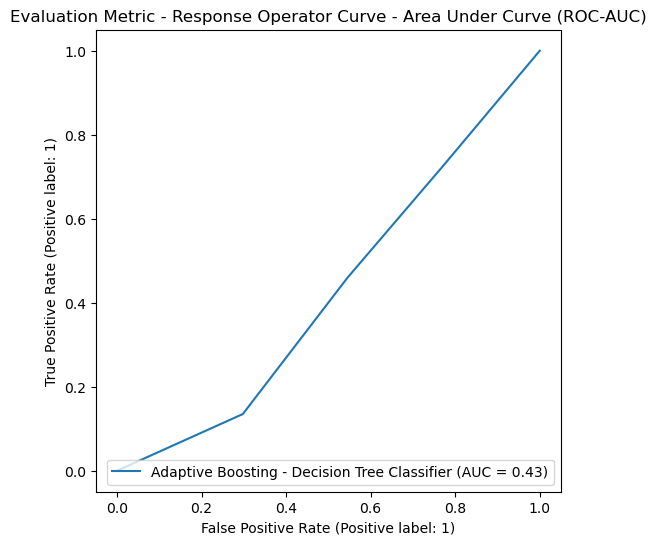

In [341]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax,
  y_true = y_test, y_pred = y_hat, pos_label = 1,
  name = "Adaptive Boosting - Decision Tree Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()